# Machine Learning and Statistics
Project notebook for Machine Learning and Statistics @ GMIT - 2020

Author: Maciej Izydorek (G00387873@gmit.ie) Github: [mizydorek](https://github.com/mizydorek/Fundamentals-of-Data-Analysis-Project-2020)

***

#### Project Description

*Create a web service that uses machine learning to make predictions based on the powerproduction data set. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.*

#### Introduction to Dataset

##### — Packages

In [2]:
# Numerical arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd 

# Plotting.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# plot settings.
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16,9]

# Set your custom color palette
colors = ["#495057", "#212529", "#6C757D", "#ADB5BD", "#CED4DA"]
sns.set_palette(sns.color_palette(colors))
cmap = matplotlib.colors.ListedColormap(colors)

##### — Load Dataset

In [3]:
# Load data set.
df = pd.read_csv("https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv")

##### — Preview of dataset

In [4]:
# Preview of dataset.
df.T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
speed,0.0,0.125,0.15,0.225,0.275,0.325,0.400,0.450,0.501,0.526,...,24.499,24.525,24.575,24.65,24.75,24.775,24.85,24.875,24.95,25.0
power,0.0,0.000,0.00,0.000,0.000,4.331,5.186,3.826,1.048,5.553,...,0.000,0.000,0.000,0.00,0.00,0.000,0.00,0.000,0.00,0.0


In [5]:
# Shape of dataset.
df.shape

(500, 2)

In [6]:
# Have a look at some basic statistical details.
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


##### — Standard Missing values

In [7]:
# Check if dataset contains any missing values.
# https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b
df.isnull().sum().sum()

0

##### — Non-Standard Missing values

In [8]:
# Check if dataset contains any missing values according to specified list.
# https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe
missing_values=['n/a', 'na', '--', ' ']
df = pd.read_csv('https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv', na_values=missing_values)
df.isna().sum().sum()

0

##### — Negative values

In [9]:
# check if dataset contains any negative values
df[(df.speed < 0) & (df.power < 0)].sum().sum()

0.0

##### — Correlation

In [10]:
# Display correlation between wind speed and power output.
df.corr()

,speed,power
speed,1.000000,0.853778
power,0.853778,1.000000


From a quick preview of dataset can be seen that dataset contains 500 rows and two columns with entries for wind and power outputs displayed accordingly in meters per second (m/s) and kilowatt-hour (kWh). There is no standard, non-standard or negative values in dataset. It can also be observed that at the tail of the dataset where wind speed is max out there are zero values in power column. Let's make some plots to identify outliers.

##### — Plots

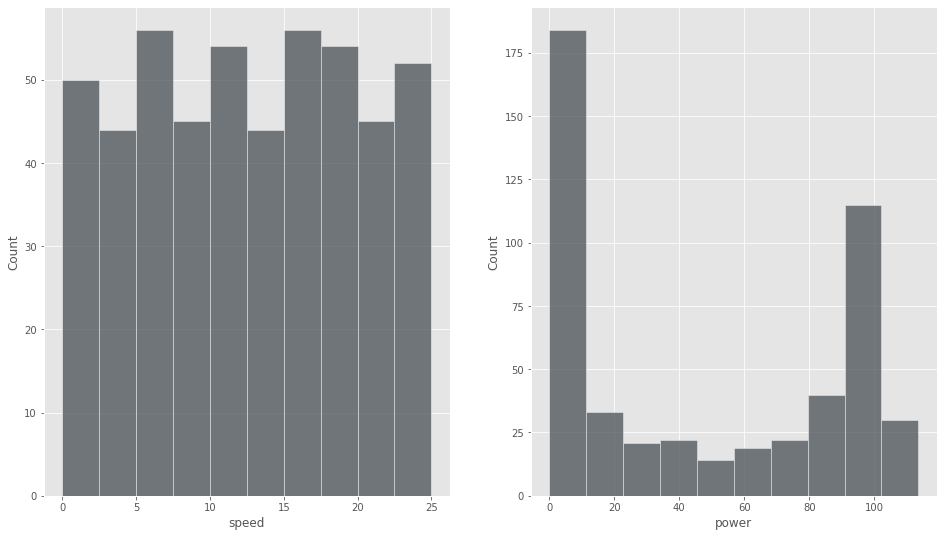

In [11]:
# check how the distribution looks like for speed and power column using hist plot.
fig, ax =plt.subplots(1,2)
sns.histplot(data=df, x="speed", ax=ax[0]);
sns.histplot(data=df, x="power", ax=ax[1]);

*Worth noting that there is a high volume of variables in a first section (0-10) of power output.*

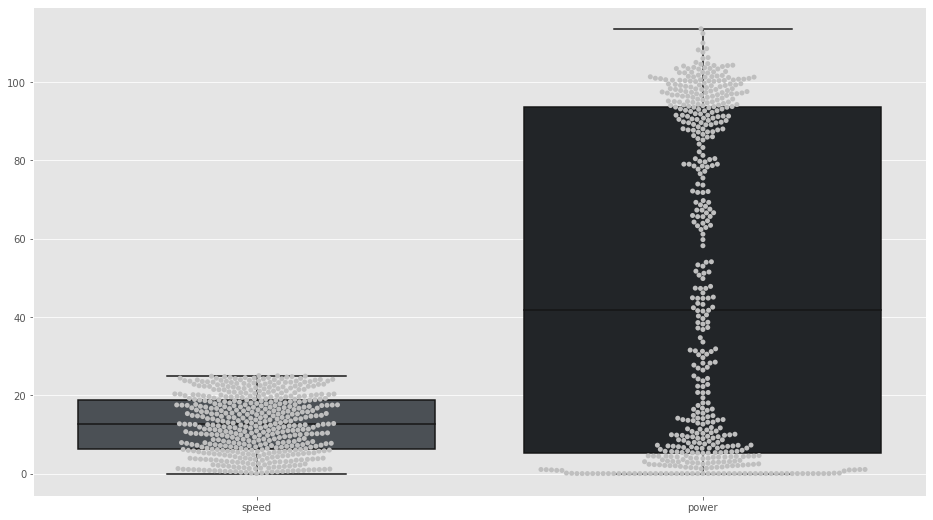

In [12]:
# Box plots are very useful to provide a visual summary of the data that enabling to identify outliers, 
# the dispersion of data set and shows if data is normally distributed or skewed.
sns.boxplot(data=df);
sns.swarmplot(data=df, color=".75");

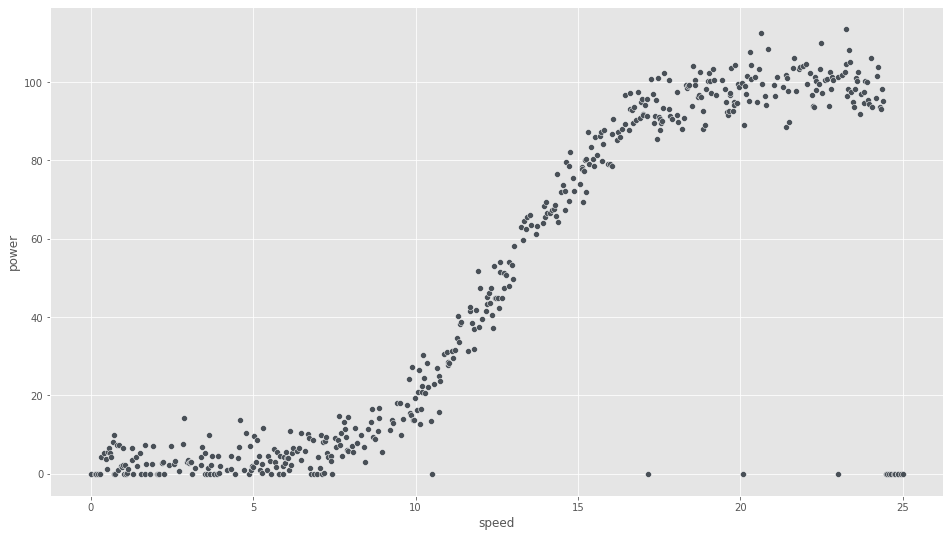

In [13]:
# Scatter plot clearly shows that we have some outliers.
sns.scatterplot(data=df, x='speed', y='power');

##### — Assumption

Taking into consideration the output from data preview and what can be observed at the scatter plot some assumption has to be made. Power turbine has to generate some power output above certain level apart from wind direction and air density which are not included in dataset so will not be taken into the consideration. Based on given dataset that includes wind speed and power output generated by power turbine, one seems to be a sweet spot.

#### Preprocessing of dataset

In [15]:
# let's remove the outliers according to assumption made above 
# finding on how to remove rows based on a conditional expression
# https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
df = df.drop(df[(df.speed > 1) & (df.power == 0)].index).reset_index(drop=True)
df.T

,0,1,2,3,4,5,6,7,8,9,...,448,449,450,451,452,453,454,455,456,457
speed,0.0,0.125,0.15,0.225,0.275,0.325,0.400,0.450,0.501,0.526,...,23.974,24.024,24.049,24.174,24.199,24.249,24.299,24.349,24.374,24.399
power,0.0,0.000,0.00,0.000,0.000,4.331,5.186,3.826,1.048,5.553,...,94.270,105.992,93.524,95.869,101.419,103.700,93.694,93.078,98.223,95.117


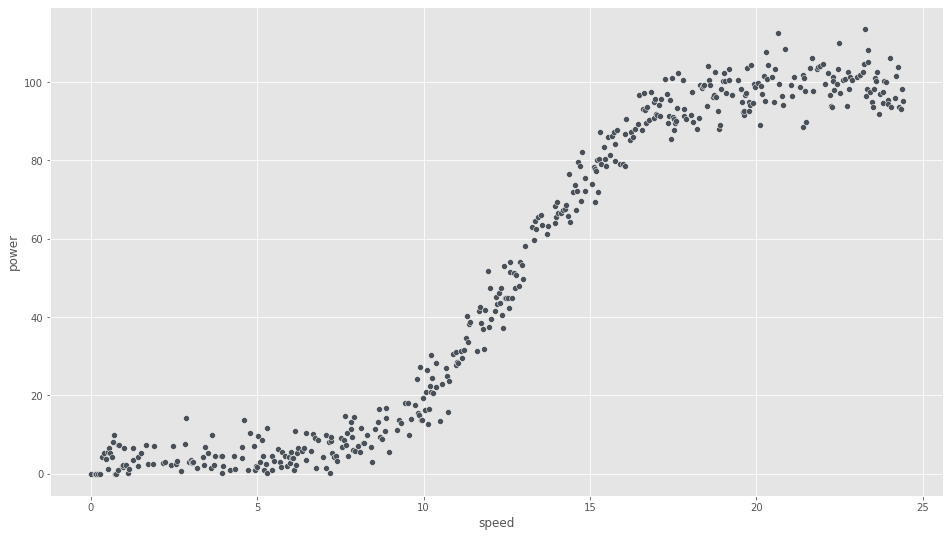

In [16]:
# plot of newly created dataset 
sns.scatterplot(data=df, x='speed', y='power');

##### — Train Test Split

##### — Assumption

In [29]:
# Convert speed and power columns to numpy arrays.
x = df['speed'].to_numpy()
y = df['power'].to_numpy()

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Using train_test_split() from the scikit-learn library, makes it easy to split dataset into training and testing data.
from sklearn.model_selection import train_test_split

# Script splits the dataset into 75% train data and 25% test data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

#### — Linear Regression

Simple linear regression is a linear regression model that examines the linear relationship between two quantitative variables by fitting a linear equation that, as accurately as possible, predicts the dependent variable values based on function of the independent variable.

A relationship between variables $y$ and $x$ is represented by equation:

$$y = m x + c$$

where $y$ is the dependent variable that will be estimate, $x$ is the independent variable that is used to make predictions, $m$ is the slope of the regression line and $c$ is a constant also known $y$ intercept (the value of $y$ when $x$ = 0).

In [30]:
# Linear Regression Using Scikit Learn
# import LinearRegression model from Scikit Learn linear model.
from sklearn.linear_model import LinearRegression


# Create a new linear model.
model = LinearRegression()

# Fit the data to the model.
model.fit(x_train, y_train)

score = model.score(x_train, y_train)

print('R-squared value: {} '.format(score))

R-squared value: 0.8997620223017813 


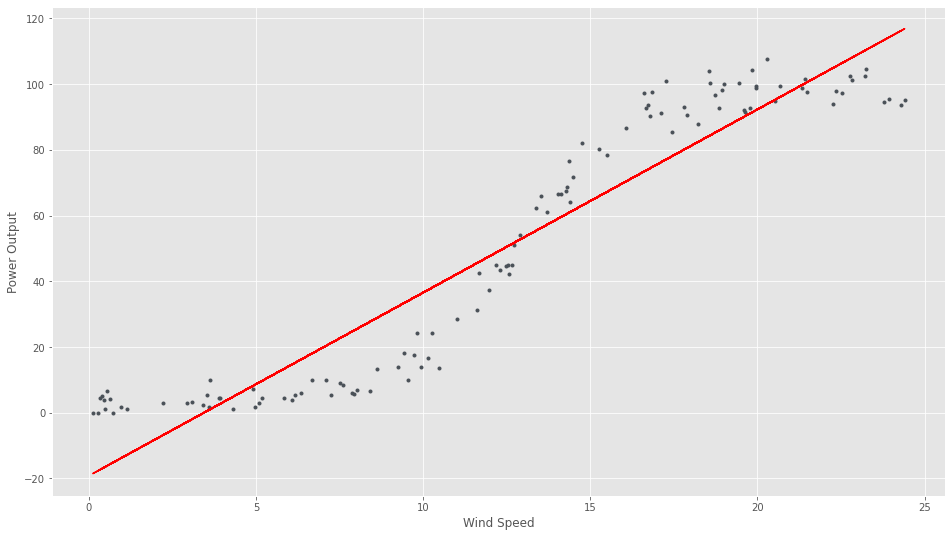

In [31]:

predict = model.predict(x_test)

# Plot speed and power and the regression line.

plt.plot(x_test, y_test, '.');
plt.plot(x_test, predict, 'r-')
plt.xlabel('Wind Speed')
plt.ylabel('Power Output');